In [1]:
# activate R magic
%load_ext rpy2.ipython

In [3]:
%%R
knitr::opts_chunk$set(echo = TRUE, comment = "#>", collapse = TRUE,
                      fig.width = 6, fig.asp = 0.618,
                      out.width = "70%", fig.align = "center")
comma <- function(x, digits. = 2L) {
    format(x, digits = digits., big.mark = ",")
}

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cp drive/MyDrive/Rlibrary.tar.gz .
!tar xf Rlibrary.tar.gz

Mounted at /content/drive
tar: Removing leading `/' from member names


In [18]:
%%R
.libPaths('usr/local/lib/R/site-library/')
library(tidyverse)
library(rstan)
rstan_options(auto_write = TRUE)  # save compiled STAN object
# library(shinystan)  # graphical exploration
library(posterior)  # for summarizing draws
library(bayesplot)  # for plotting
theme_set(theme_classic() +
    theme(panel.grid.major.y = element_line(color = "grey92")))


Attaching package: ‘posterior’



    ess_bulk, ess_tail



    mad, sd, var



    %in%, match







Attaching package: ‘bayesplot’



    rhat




Although many statistical models can be fitted using Bayesian or frequentist methods, some models are more naturally used in the Bayesian framework. One class of such models is the family of **hierarchical models.** Consider situations when the data contain some *clusters*, such as multiple data points in each of many participants, multiple participants in each of several treatment conditions, etc. While it is possible to run $J$ Bayesian analyses for the $J$ subsets of the data, it is usually more efficient to *pool* the data together, such that cluster $j$ has some parameters $\theta_j$, and these $J$ $\theta$ values themselves come from a common distribution. This is the same idea as *multilevel modeling*.

In this note, you will see two examples, one from the textbook with a hierarchical Bernoulli/binomial model, and another from a classic data set with eight schools, modelled by a hierarchical normal model.

# Hierarchical Bernoulli/Binomial

Previously, we have seen the Bernoulli model for $N$ outcomes, such as multiple coin flips from the same coin:
$$y_i \sim \text{Bern}(\theta_i), \text{for }i = 1, \ldots, N$$
We assumed exchangeability as the flips are from the same coin.

## Alternative Parameterization of Beta

Previously we have used the Beta(a, b) prior for a Bernoulli outcome, such that
$$P(\theta \mid a, b) \propto \theta^{a - 1} (1 - \theta)^{b - 1}.$$
However, in hierarchical models to be discussed later, it is beneficial to consider another way to express the Beta distribution, in terms of the *prior mean*, $\mu = a / (a + b)$, $\mu \in [0, 1]$, and the concentration, $\kappa = a + b$, $\kappa \in [0, \infty)$. So instead of the above formula, we can write
$$P(\theta \mid \mu, \kappa) \propto \theta^{\mu \kappa - 1} (1 - \theta)^{(1 - \mu) \kappa - 1}.$$
The two expressions represent exactly the same distribution, but just in terms of parameters of different meanings. Therefore, they are referred to as **different parameterization** of the Beta distribution.

<aside>
Note your textbook used $\omega$ = $(a - 1) / (a + b - 2)$ for the mode, instead of the mean. This is yet another parameterization in terms of $\omega$ and $\kappa$, but I found the mean parameterization more natural and common in the literature.
</aside>

## Multiple Bernoulli = Binomial

With $N$ exchangeable Bernoulli observations, an equivalent but more efficient way to code the model is to use the *binomial* distribution. Let $z = \sum_{i = 1}^N y_i$, then
$$z \sim \mathrm{Bin}(N, \theta)$$

## Multiple Binomial Observations

Now, consider the situation with multiple coins, perhaps each coin with some noticeable differences, as discussed in chapter 9.2 of the textbook. If we have $J$ = 3 coins, and $N_j$ flips for the $j$th coin. If we believe that the coins all have the same bias, then we could consider the model
$$z_j \sim \mathrm{Bin}(N_j, \theta),$$
which still contains only one parameter, $\theta$. However, if we have reason to believe that the coins have different biases, then we should have
$$z_j \sim \mathrm{Bin}(N_j, \theta_{\color{red}{j}}),$$
with parameters $\theta_1, \ldots, \theta_j$.

We can assign priors to each individual $\theta_j$. However, if our prior belief is such that there's something common among the different coins, say they're from the same factory, so that they come from the same distribution, we can have common parameters for the prior distributions of the $\theta$s:
$$\theta_j \sim \mathrm{Beta2}(\mu, \kappa),$$
note I use Beta2 to denote the mean parameterization. Here, we express the prior belief that the **mean bias** of the different coins is $\mu$, and how each coin is different from the mean depends on $\kappa$. Now, $\mu$ and $\kappa$ are hyperparameters. We can assign some fixed values to $\mu$ and $\kappa$, as if we know what the average bias is. However, the power of the hierarchical model is that we can put priors (or hyper priors) on $\mu$ and $\kappa$, and obtain posterior distributions of them, based on what the data say.

What priors to use for $\mu$ and $\kappa$? $\mu$ is relatively easy because it is the mean bias; if we put a Beta prior for bias, we can again use a Beta prior for the mean bias. $\kappa$ is more challenging. A larger $\kappa$ means that the biases of the coins are more similar to each other. We can perform a prior predictive check to see what the data look like. As a starting point, chapter 9 of the textbook suggested using Gamma(0.01, 0.01). So the full model in our case, with a weak Beta(1.5, 1.5) prior on $\mu$, is

Model:
$$
  \begin{aligned}
    z_j & \sim \mathrm{Bin}(N_j, \theta_j) \\
    \theta_j & \sim \mathrm{Beta2}(\mu, \kappa)
  \end{aligned}
$$
Prior:
$$
  \begin{aligned}
    \mu & \sim \mathrm{Beta}(1.5, 1.5) \\
    \kappa & \sim \mathrm{Gamma}(0.01, 0.01)
  \end{aligned}
$$

## Therapeutic Touch Example

See the description of the research problem from chapter 9.2.4 of the textbook.

In [10]:
%%R
# Data file from https://github.com/boboppie/kruschke-doing_bayesian_data_analysis/blob/master/2e/TherapeuticTouchData.csv
# tt_dat <- read.csv("data_files/TherapeuticTouchData.csv")
tt_dat <- read.csv("https://raw.githubusercontent.com/boboppie/kruschke-doing_bayesian_data_analysis/master/2e/TherapeuticTouchData.csv")
# Get aggregated data by summing the counts
tt_agg <- tt_dat %>%
    group_by(s) %>%
    summarise(y = sum(y),  # total number of correct
              n = n())
# Plot proportion correct distribution
p1 <- ggplot(tt_agg, aes(x = y / n)) +
    geom_histogram(binwidth = .1) +
    labs(x = "Proportion Correct")

In [11]:
%%
p1

UsageError: Cell magic `%%` not found.


### Prior predictive

You can use Stan to sample the prior by commenting out the model line; here I show how to do it in R:

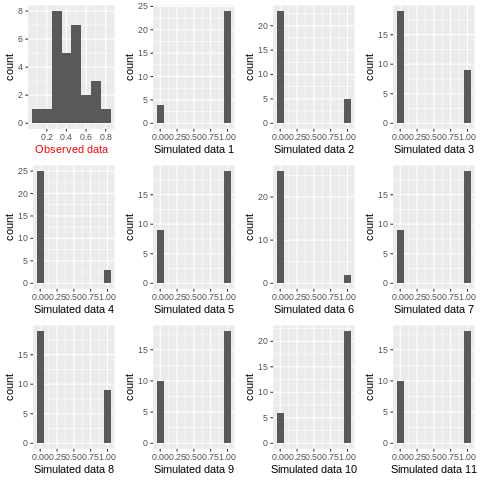

In [12]:
%%R
set.seed(1706)
plist <- vector("list", 12L)
plist[[1]] <- p1 +
    labs(x = "Observed data") +
    theme(axis.title.x = element_text(color = "red"))
num_subjects <- 28
for (s in 1:11) {
    # Get prior values of mu and kappa
    mu_s <- rbeta(1, shape1 = 1.5, shape2 = 1.5)
    kappa_s <- rgamma(1, shape = 0.01, rate = 0.01)
    # Generate theta
    theta <- rbeta(num_subjects,
                   shape1 = mu_s * kappa_s, shape2 = (1 - mu_s) * kappa_s)
    # Generate data
    new_y <- rbinom(num_subjects, size = tt_agg$n, prob = theta)
    plist[[s + 1]] <-
        p1 %+% mutate(tt_agg, y = new_y) +
        labs(x = paste("Simulated data", s)) +
        theme(axis.title.x = element_text(color = "black"))
}
gridExtra::grid.arrange(grobs = plist, nrow = 3)

The prior on $\kappa$ is actually not very realistic because it tends to push the bias to either 0 or 1. Using something like Gamma(0.1, 0.1) or Gamma(2, 0.01) may be a bit more reasonable (you can try it out yourself).

### Calling `rstan`

In [13]:
%%R
tt_fit <- stan(
    file = "hierarchical_bin.stan",
    data = list(J = nrow(tt_agg),
                y = tt_agg$y,
                N = tt_agg$n),
    seed = 1716,  # for reproducibility
    chains = 4,
    iter = 4000,  # default gives warning saying iter needs to be higher
    # may need higher adapt_delta (default = .8) for hierarchical models
    control = list(adapt_delta = 0.8)
)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 4.5e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 4000 [  0%]  (Warmup)
Chain 1: Iteration:  400 / 4000 [ 10%]  (Warmup)
Chain 1: Iteration:  800 / 4000 [ 20%]  (Warmup)
Chain 1: Iteration: 1200 / 4000 [ 30%]  (Warmup)
Chain 1: Iteration: 1600 / 4000 [ 40%]  (Warmup)
Chain 1: Iteration: 2000 / 4000 [ 50%]  (Warmup)
Chain 1: Iteration: 2001 / 4000 [ 50%]  (Sampling)
Chain 1: Iteration: 2400 / 4000 [ 60%]  (Sampling)
Chain 1: Iteration: 2800 / 4000 [ 70%]  (Sampling)
Chain 1: Iteration: 3200 / 4000 [ 80%]  (Sampling)
Chain 1: Iteration: 3600 / 4000 [ 90%]  (Sampling)
Chain 1: Iteration: 4000 / 4000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.814 seconds (Warm-up)
Chain 1:                0.556 seconds (Sampling)
Chain 1:                1.37

You can explore the convergence and posterior distributions using the `shinystan` package

In [14]:
%%R
launch_shinystan(tt_fit)

  could not find function "launch_shinystan"


 




Error in launch_shinystan(tt_fit) : 
  could not find function "launch_shinystan"


### Table of coefficients

In [19]:
%%R
tt_fit %>%
    # Convert to `draws` object to work with the `posterior` package
    as_draws() %>%
    # Get summary
    summarize_draws() %>%
    # Use `knitr::kable()` for tabulation
    knitr::kable(digits = 2)



|variable  |    mean|  median|    sd|   mad|      q5|     q95| rhat| ess_bulk| ess_tail|
|:---------|-------:|-------:|-----:|-----:|-------:|-------:|----:|--------:|--------:|
|theta[1]  |    0.37|    0.37|  0.08|  0.08|    0.22|    0.49| 1.00|  2391.10|  3595.39|
|theta[2]  |    0.39|    0.39|  0.08|  0.08|    0.24|    0.51| 1.00|  3261.16|  3793.78|
|theta[3]  |    0.41|    0.41|  0.08|  0.07|    0.27|    0.53| 1.00|  4974.26|  3689.93|
|theta[4]  |    0.41|    0.41|  0.08|  0.07|    0.27|    0.53| 1.00|  5123.21|  4846.51|
|theta[5]  |    0.41|    0.41|  0.08|  0.07|    0.27|    0.53| 1.00|  4729.48|  3929.00|
|theta[6]  |    0.41|    0.41|  0.08|  0.07|    0.28|    0.53| 1.00|  4590.63|  4684.32|
|theta[7]  |    0.41|    0.41|  0.08|  0.07|    0.27|    0.54| 1.00|  4834.44|  4216.26|
|theta[8]  |    0.41|    0.41|  0.08|  0.07|    0.28|    0.53| 1.00|  4506.89|  4343.56|
|theta[9]  |    0.41|    0.41|  0.08|  0.07|    0.27|    0.53| 1.00|  4597.78|  3994.53|
|theta[10] |    0.4

### Derived coefficients

One nice thing about MCMC is that it is straightforward to obtain posterior distributions that are functions of the parameters. For example, even though we only sampled from the posteriors of the $\theta$s, we can ask questions like whether there is evidence for a nonzero *difference* in $\theta$ between person 1 and person 28.

In [20]:
%%R
as_draws_df(tt_fit) %>%
    mutate_variables(
        theta1_minus14 = `theta[1]` - `theta[14]`,
        theta1_minus28 = `theta[1]` - `theta[28]`,
        theta14_minus28 = `theta[14]` - `theta[28]`
    ) %>%
    subset(variable = c("theta1_minus14", "theta1_minus28",
                        "theta14_minus28")) %>%
    summarise_draws()

# A tibble: 3 × 10
  variable       mean  median    sd    mad     q5    q95  rhat ess_bulk ess_tail
  <chr>         <num>   <num> <num>  <num>  <num>  <num> <num>    <num>    <num>
1 theta1_min… -0.0651 -0.0569 0.106 0.0965 -0.252 0.0900  1.00    5408.    4387.
2 theta1_min… -0.153  -0.135  0.129 0.123  -0.394 0.0258  1.00    1816.    3839.
3 theta14_mi… -0.0880 -0.0739 0.113 0.105  -0.295 0.0718  1.00    4036.    3856.


### Conclusion

As 0.5 is included in the 95% CI of $\theta$ for all participants, there is insufficient evidence that people can sense "therapeutic touch."

## Shrinkage

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


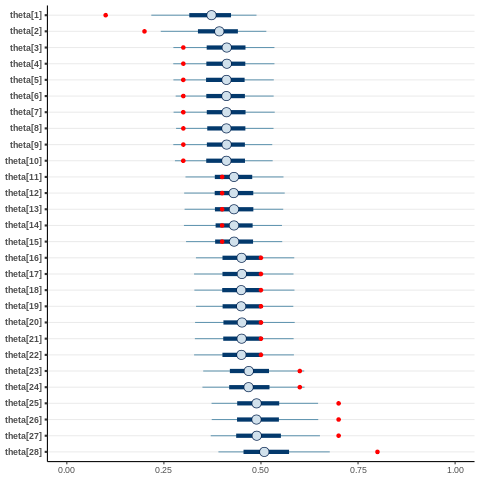

In [21]:
%%R
mcmc_intervals(tt_fit,
               # plot only parameters matching "theta"
               regex_pars = "theta") +
    geom_point(
        data = tibble(
            parameter = paste0("theta[", 1:28, "]"),
            x = tt_agg$y / tt_agg$n
        ),
        aes(x = x, y = parameter),
        col = "red"
    ) +
    xlim(0, 1)

As can be seen, the posterior distributions are closer to the center than the data (in red). This **pooling** is a result of the belief that the participants have something in common.

### Multiple Comparisons?

Another benefit of a Bayesian hierarchical model is that *you don't need to worry about multiple comparisons*. There are multiple angles on why this is the case, but the basic answer is that the use of common prior distributions builds in the prior belief that the clusters/groups are likely to be equal. See discussion [here](https://statmodeling.stat.columbia.edu/2016/08/22/bayesian-inference-completely-solves-the-multiple-comparisons-problem/) and [here](https://stats.stackexchange.com/questions/203378/why-dont-bayesian-methods-require-multiple-testing-corrections).

# Hierarchical Normal Model

## Eight Schools Example

This is a classic data set first analyzed by [Rubin (1981)](https://journals.sagepub.com/doi/abs/10.3102/10769986006004377). It is also the example used in the [RStan Getting Started](https://github.com/stan-dev/rstan/wiki/RStan-Getting-Started) page. The data contains the effect of coaching from randomized experiments in eight schools. The numbers shown (labelled as `y`) are the mean difference (i.e., effect size) in performance between the treatment group and the control group on SAT-V scores.

In [22]:
%%R
schools_dat <- list(J = 8,
                    y = c(28, 8, -3,  7, -1, 1, 18, 12),
                    sigma = c(15, 10, 16, 11, 9, 11, 10, 18))

In the above data, some numbers are positive, and some are negative. Because the sample sizes are different, the data also contained the standard errors (labelled as `sigma`) of the effect sizes. Generally speaking, a larger sample size corresponds to a smaller standard error. The research question is

> 1. What is the average treatment effect of coaching?
> 2. Are the treatment effects similar across schools?

## Model

Model:
$$
  \begin{aligned}
    d_j & \sim N(\theta_j, s_j) \\
    \theta_j & \sim N(\mu, \tau)
  \end{aligned}
$$
Prior:
$$
  \begin{aligned}
    \mu & \sim N(0, 100) \\
    \tau & \sim t^+_4(0, 100)
  \end{aligned}
$$

Given the SAT score range, it is unlikely that a coaching program will improve scores by 100 or so, so we use a prior of $\mu \sim N(0, 100)$ and $\tau \sim t^+_4(0, 100)$.

Note: The model above is the same as one used in a *random-effect meta-analysis*. See [this paper](https://onlinelibrary.wiley.com/doi/abs/10.1002/jrsm.12) for an introduction.

## Non-Centered Parameterization

The hierarchical model is known to create issues in MCMC sampling, such that the posterior draws tend to be highly correlated even with more advanced techniques like HMC. One way to alleviate that is to reparameterize the model using what is called the **non-centered parameterization**. The basic idea is that, instead of treating the $\theta$s as parameters, one uses the **standardized deviation** from the mean to be parameters. You can think about it as converting the $\theta$s into $z$ scores, and then sample the $z$ scores instead of the original $\theta$s.

Model:
$$
  \begin{aligned}
    d_j & \sim N(\theta_j, s_j) \\
    \theta_j & = \mu + \tau \eta_j \\
    \eta_j & \sim N(0, 1)
  \end{aligned}
$$

In [23]:
%%R
fit <- stan(
    file = "hierarchical_norm.stan",
    data = schools_dat,
    seed = 1804,  # for reproducibility
    # higher adapt_delta due to divergent transitions
    pars = c("mu", "tau", "theta"),  # skip the etas
    control = list(adapt_delta = 0.95)
)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.1e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.205 seconds (Warm-up)
Chain 1:                0.153 seconds (Sampling)
Chain 1:                0.35

Treatment effect estimates of individual schools ($\theta$), average treatment effect ($\mu$), and treatment effect heterogeneity ($\tau$).

In [24]:
%%R
print(fit, pars = c("theta", "mu", "tau"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean   sd   2.5%  25%   50%   75% 97.5% n_eff Rhat
theta[1] 11.56    0.16 8.54  -2.14 6.10 10.46 15.72 32.27  2787    1
theta[2]  7.75    0.10 6.31  -4.53 3.80  7.55 11.83 20.52  4335    1
theta[3]  5.71    0.14 8.02 -13.34 1.58  6.28 10.54 20.48  3404    1
theta[4]  7.44    0.09 6.51  -5.51 3.50  7.37 11.32 20.69  4858    1
theta[5]  4.91    0.10 6.35  -8.90 1.17  5.32  9.08 16.67  4033    1
theta[6]  5.99    0.10 6.72  -8.89 2.11  6.43 10.34 18.15  4362    1
theta[7] 10.74    0.11 6.65  -0.93 6.39 10.10 14.63 25.97  3396    1
theta[8]  8.47    0.12 7.75  -6.94 4.06  8.14 12.56 24.84  4054    1
mu        7.70    0.14 5.45  -2.54 4.41  7.65 10.85 18.25  1502    1
tau       6.84    0.17 5.84   0.26 2.57  5.49  9.39 21.62  1115    1

Samples were drawn using NUTS(diag_e) at Thu Nov  2 12:43:55 2023.
For each paramete

On average, based on the 95% CI, coaching seemed to improve SAT-V by -2.2 to 17.54 points. There was substantial heterogeneity across schools.

We can also get the probability that the treatment effect was > 0:

In [25]:
%%R
# Obtain draws
mu_draws <- as.matrix(fit, pars = "mu")
mean(mu_draws > 0)

[1] 0.94


Here are the individual-school treatment effects:

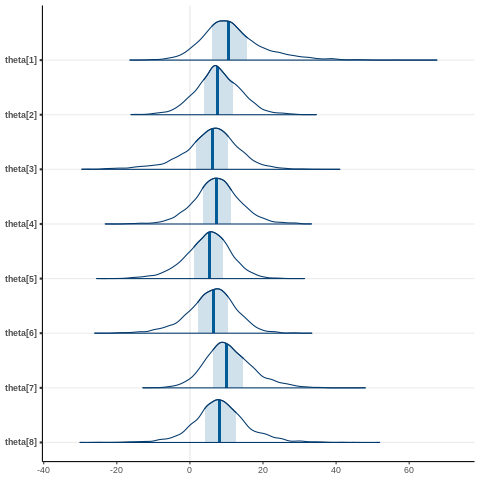

In [26]:
%%R
mcmc_areas(fit, regex_pars = "theta")

## Prediction Interval

Posterior distribution of the true effect size of a new study, $\tilde \theta$

In [27]:
%%R
# Prediction Interval (can also be done in Stan)
extract(fit, pars = c("mu", "tau")) %>%
    as_draws_array() %>%
    mutate_variables(theta_tilde = rnorm(4000, mean = mu, sd = tau)) %>%
    summarise_draws()

# A tibble: 3 × 10
  variable     mean median    sd   mad     q5   q95  rhat ess_bulk ess_tail
  <chr>       <num>  <num> <num> <num>  <num> <num> <num>    <num>    <num>
1 mu           7.70   7.65  5.45  4.79 -0.411  16.4  1.00    4120.    3959.
2 tau          6.84   5.49  5.84  4.78  0.567  17.8  1.00    3937.    3882.
3 theta_tilde  7.69   7.57 10.3   7.18 -8.07   23.5  1.00    3915.    3834.


The posterior interval for $\tilde \theta$ indicates a range that the treatment effect for a new study can be.

<!-- The following chunk is only used in the website -->